# 02 - Estimating Seats offered on routes unavailable open-source

Author: **A. Salgas** (antoine.salgas@isae-supaero.fr)

This notebook is the direct continuation of (03_routes_schedule/01_routes_preparation.ipynb)

Several traffic estimation model are tested:

To do so:

- most simple models are tested first and their limits are explored
- a XGBoost model is used to estimate the seats on route where this value is unknown.



We found open-source seating capacity for around 60% of the routes parsed on wikipedia.  
We have around 3.4 billions seats, while the passengers traffic was about 4.56 billions (see below) in 2019.
Using an average Load factor of 82.6%  (https://www.iata.org/en/iata-repository/publications/economic-reports/air-passenger-monthly---dec-2019/), it means that 5.52 billions seats were available, or that we cover 61.2% of teh seats avaiable before the estimation.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import IFrame
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import plotly.express as px

In [2]:
IFrame(
    "https://data.worldbank.org/share/widget?indicators=IS.AIR.PSGR",
    width=700,
    height=450,
)

## Data exploration

In [3]:
# Loading the data from the previous notebook

routes_df_0 = pd.read_csv(
    "data/routes_processed_26_09.csv", keep_default_na=False, na_values=["", "NaN"]
)

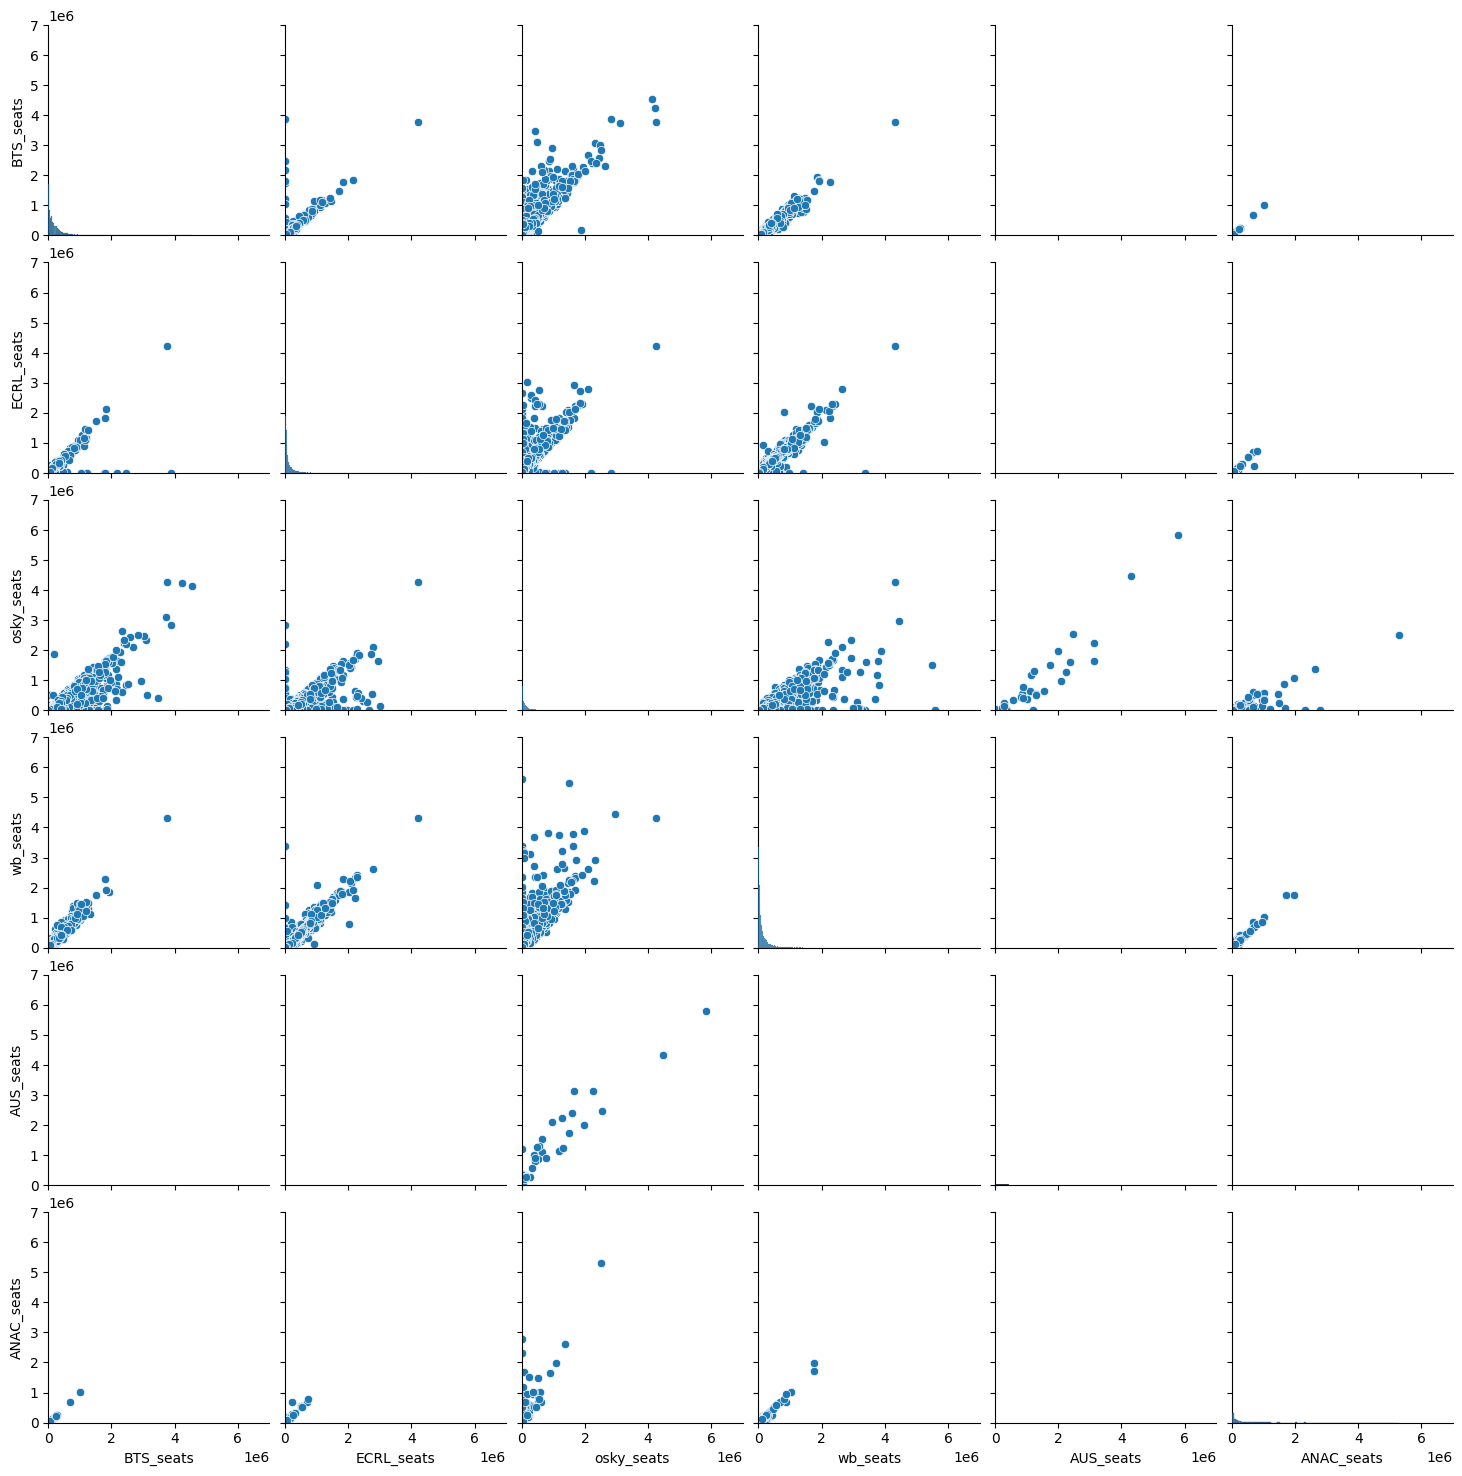

In [4]:
# Plotting the pairplots of the major different sources to check data consistency.

pd.options.display.max_rows = 20
pd.options.display.max_columns = 90
ax = sns.pairplot(
    routes_df_0[
        ["BTS_seats", "ECRL_seats", "osky_seats", "wb_seats", "AUS_seats", "ANAC_seats"]
    ]
)
for axi in ax.axes:
    for axj in axi:
        axj.set_xlim([0, 7000000])
        axj.set_ylim([0, 7000000])

On the plot above, it can be seen that Opensky tends to underestimated the number of seats offered on a route when that route is also present on another data source.  
This might be linked to the fact that some flight origin/destination or aircraft were unknown and thus not included in our dataset.  
The same is true, although less visible for eurocontrol data. BTS/World bank/Australian and Brasilian datasets are consistent. 


## Data preparation

In [96]:
# Removing data on sources if the route is too small (only some flights on a route are detected for instance), to reduce the impacts on the learning process.

# routes_df_0['osky_seats']=routes_df_0.apply(lambda row: row['osky_seats'] if row['osky_seats']>10000 else np.nan, axis=1)
# routes_df_0['ECRL_seats']=routes_df_0.apply(lambda row: row['ECRL_seats'] if row['ECRL_seats']>10000 else np.nan, axis=1)

routes_df_0["consolidated_seats"] = routes_df_0.apply(
    lambda row: row["consolidated_seats"]
    if row["consolidated_seats"] > 1000
    else np.nan,
    axis=1,
)

In [97]:
routes_df_0.columns

Index(['Unnamed: 0', 'sorted_origin', 'sorted_destination', 'Regular',
       'Seasonal', 'Seasonal charter', 'Unnamed: 0.1_departure',
       'Unnamed: 0_departure', 'max_population_departure',
       'max_passengers19_departure', 'maxpax_departure', 'wdpa_link_departure',
       'lat_departure', 'lon_departure', 'iata_departure', 'icao_departure',
       'ISO_country_departure', 'ISO_continent_departure',
       'year_pax_round2_departure', 'pax_round2_departure',
       'consolidated_pax_departure', 'h3_departure', 'pop_30k_departure',
       'airport_30k_departure', 'pax_h3_30k_departure', 'pop_70k_departure',
       'airport_70k_departure', 'pax_h3_70k_departure', 'pop_150k_departure',
       'airport_150k_departure', 'pax_h3_150k_departure', 'GDP PPP_departure',
       'Gini_departure', 'Surf_departure', 'toursim_export_share_departure',
       'visiting_tourists_departure', 'outbound_tourists_departure',
       'IHDI_departure', 'is_country_island_departure', 'Unnamed: 0.1_arriv

Removing unecessary columns (redundant variables)

In [98]:
col_list = [
    "Regular",
    "Seasonal",
    "Seasonal charter",
    "iata_departure",
    "ISO_country_departure",
    "ISO_continent_departure",
    "consolidated_pax_departure",
    "pop_30k_departure",
    "airport_30k_departure",
    "pax_h3_30k_departure",
    "pop_70k_departure",
    "airport_70k_departure",
    "pax_h3_70k_departure",
    "pop_150k_departure",
    "airport_150k_departure",
    "pax_h3_150k_departure",
    "GDP PPP_departure",
    "Gini_departure",
    "Surf_departure",
    "toursim_export_share_departure",
    "visiting_tourists_departure",
    "outbound_tourists_departure",
    "IHDI_departure",
    "is_country_island_departure",
    "iata_arrival",
    "ISO_country_arrival",
    "ISO_continent_arrival",
    "consolidated_pax_arrival",
    "pop_30k_arrival",
    "airport_30k_arrival",
    "pax_h3_30k_arrival",
    "pop_70k_arrival",
    "airport_70k_arrival",
    "pax_h3_70k_arrival",
    "pop_150k_arrival",
    "airport_150k_arrival",
    "pax_h3_150k_arrival",
    "GDP PPP_arrival",
    "Gini_arrival",
    "Surf_arrival",
    "toursim_export_share_arrival",
    "visiting_tourists_arrival",
    "outbound_tourists_arrival",
    "IHDI_arrival",
    "is_country_island_arrival",
    "trade_value",
    "distance_km",
    "domestic",
    "consolidated_seats",
]

In [99]:
routes_df = routes_df_0[col_list]

Keeping only the data with known dependent variable.

In [100]:
routes_df_known = routes_df.dropna(subset="consolidated_seats")

Some regression algorithms are not suited to handle categorical variables (or requires the use of n binary variables for n diffrent values of a variable -> "One-Hot Encoding", which in the case of a country variable  would likely introduce to much variables in the problem).  
A sub-dataset containing only the numerical variables is thus created.

In [101]:
routes_num_only = routes_df_known.drop(
    columns={
        "trade_value",
        "iata_departure",
        "ISO_country_departure",
        "ISO_continent_departure",
        "iata_arrival",
        "ISO_country_arrival",
        "ISO_continent_arrival",
    }
)

## Linear Regression

The first regression that is going to be tested is the multilenear regression, as it is the simplest. It requires using only numerical features, not using "One-Hot Encoding" .

We have many NaN in our features. This could be pretty bad for estimation using simple linear regression.  
There are two strategies to handle this, either removing the nan rows or imputing a values suech a the median.  
In our case, there could be a link between a low value of the feature and the presence of nan: e.g the smaller an airport is the higher the chances are that the number of passengers having transited through this airport is unknown.  
The regression should perform better when nan are deleted because of higher quality data. Therefore the first strategy is used and should the results be good, the second will be tested. 

In [115]:
pd.options.display.max_rows = 50
routes_num_only.isna().sum()
routes_num_only.dropna(inplace=True)

In [116]:
# dependent variable is split from the rest

X = routes_num_only.drop(columns=["consolidated_seats"]).copy()
y = routes_num_only["consolidated_seats"]

Alternative to set a defined value to NaN. (comment the dropna then)

In [117]:
# imputer = SimpleImputer(strategy='median', missing_values=np.nan)
# imputer = imputer.fit(X)
# X[X.columns[:]] = imputer.transform(X)

In [118]:
X.isna().sum()

Regular                           0
Seasonal                          0
Seasonal charter                  0
consolidated_pax_departure        0
pop_30k_departure                 0
airport_30k_departure             0
pax_h3_30k_departure              0
pop_70k_departure                 0
airport_70k_departure             0
pax_h3_70k_departure              0
pop_150k_departure                0
airport_150k_departure            0
pax_h3_150k_departure             0
GDP PPP_departure                 0
Gini_departure                    0
Surf_departure                    0
toursim_export_share_departure    0
visiting_tourists_departure       0
outbound_tourists_departure       0
IHDI_departure                    0
is_country_island_departure       0
consolidated_pax_arrival          0
pop_30k_arrival                   0
airport_30k_arrival               0
pax_h3_30k_arrival                0
pop_70k_arrival                   0
airport_70k_arrival               0
pax_h3_70k_arrival          

In [119]:
# Train/test datasets split (80% -20%)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=12
)

In [120]:
# import of the linear regressor and a few metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

# fit the model to the data
model = LinearRegression()
model.fit(X_train, y_train)

# take model coefficients
b0 = model.intercept_.round(2)
b1 = model.coef_.round(2)

# predict the dependent variable for the test subset
y_predict = model.predict(X_test)

In [121]:
# Evaluate the mean absolute error

mae = mean_absolute_error(y_test, y_predict)
print("MAE:\t", mae.round(2))

MAE:	 161585.84


In [122]:
# Evaluate the median absolute error

medae = median_absolute_error(y_test, y_predict)
print("MedAE:\t", medae.round(2))

MedAE:	 111596.48


In [123]:
# Evaluate the root mean squared error

rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print("RMSE:\t", rmse.round(2))

RMSE:	 329448.25


In [124]:
# Evaluate the r squared score

r2 = r2_score(y_test, y_predict)
print("R2:\t", r2.round(3))

R2:	 0.398


As highlighted by this relatively low r2 value, the linear regressor fails to completely capture data's variance. 
Thus the linear regression model as constructed above might not be the more adapted for our problem.

In [125]:
b0, b1

(-880478.22,
 array([ 1.6446223e+05,  1.7223970e+04,  3.1933360e+04,  0.0000000e+00,
         1.0000000e-02, -2.5697940e+04,  0.0000000e+00, -0.0000000e+00,
         2.0262100e+03,  0.0000000e+00, -0.0000000e+00,  5.3969000e+03,
         0.0000000e+00, -1.2000000e+00,  2.6981000e+02, -0.0000000e+00,
        -5.9114000e+02, -0.0000000e+00, -0.0000000e+00,  3.3416110e+05,
        -2.3955940e+04,  0.0000000e+00,  0.0000000e+00, -2.7202990e+04,
         0.0000000e+00, -0.0000000e+00,  1.9971750e+04,  0.0000000e+00,
        -0.0000000e+00, -3.1055800e+03, -0.0000000e+00, -2.0000000e-02,
         5.1546700e+03, -1.0000000e-02,  3.2712000e+02, -0.0000000e+00,
        -0.0000000e+00,  4.2014224e+05, -2.2104380e+04, -1.8920000e+01,
         1.0492052e+05]))

What does it means in terms of general seat capacity trend?

<Axes: ylabel='Count'>

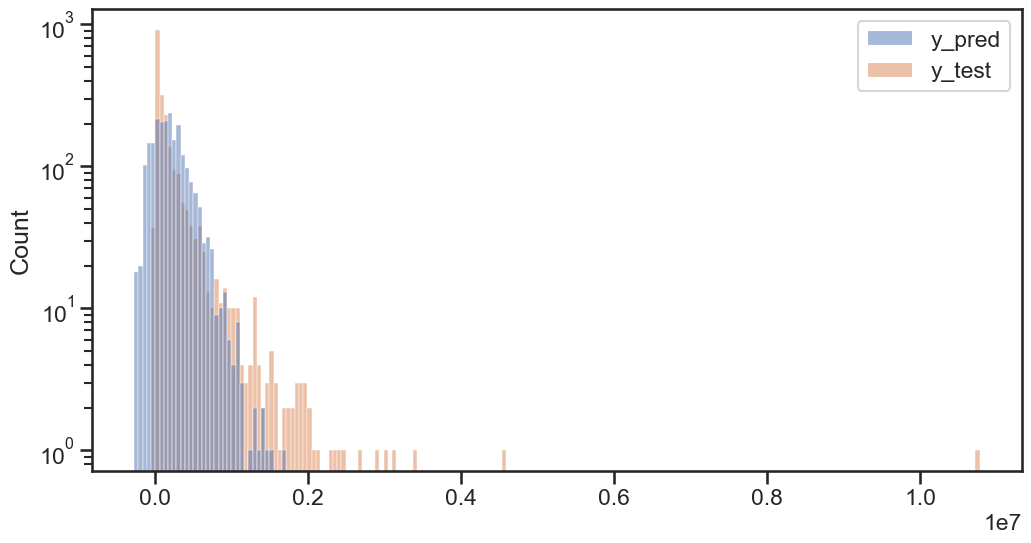

In [126]:
import matplotlib.pyplot as plt

data_dict = {"y_pred": y_predict, "y_test": y_test}
df = pd.DataFrame(data_dict)
sns.set(style="ticks", context="talk", rc={"figure.figsize": (12, 6)})
plt.yscale("log")
sns.histplot(df, bins=200)

The linear regressor allows negative seats capacity, which is very unconvinient. It's more problematic than the relatively low r².  
The number of routes with low capacity is underestimated, probably because some of them might be estimated with negative capacity. The very highly frequented routes are also poorly acknowledged. The number of intermediate routes is overestimated.   
It suggets that the relation is not linear, at least for some of the predictors.  
*(The graph above has a log y-scale)*

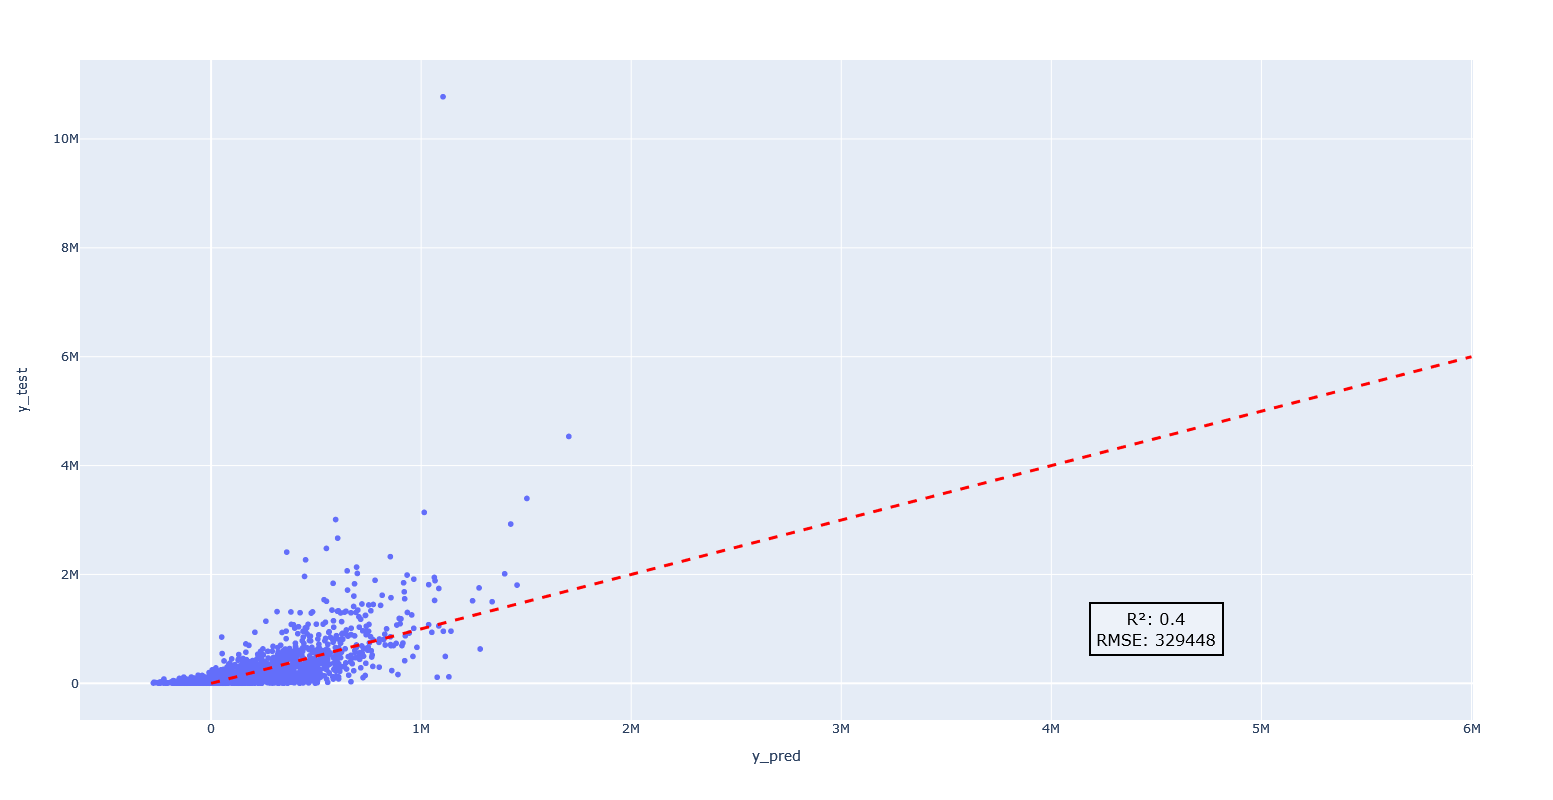

In [127]:
fig_lr = px.scatter(df, x="y_pred", y="y_test", width=800, height=800)
fig_lr.add_shape(
    type="line",
    x0=0,
    x1=6e6,
    y0=0,
    y1=6e6,
    line=dict(color="red", width=3, dash="dash"),
)


# Add text annotation
fig_lr.add_annotation(
    text="R²: {}<br>RMSE: {}".format(
        r2.round(2), int(rmse)
    ),  # Replace with your desired text
    x=4.5e6,  # X-coordinate of the text
    y=1e6,  # Y-coordinate of the text
    showarrow=False,  # To hide the arrow
    font=dict(size=16, color="black"),  # Customize the font style
    bgcolor="rgba(255, 255, 255, 0.3)",  # Background color with transparency
    bordercolor="black",  # Border color
    borderwidth=2,  # Border width
    borderpad=4,  # Padding for the border
)

fig_lr

As a first, naive approach, all the parameters were kept. Many of the are in fact **colinear** as it can be seen on teh correlation graph below, which is bad for a linear regressor. 

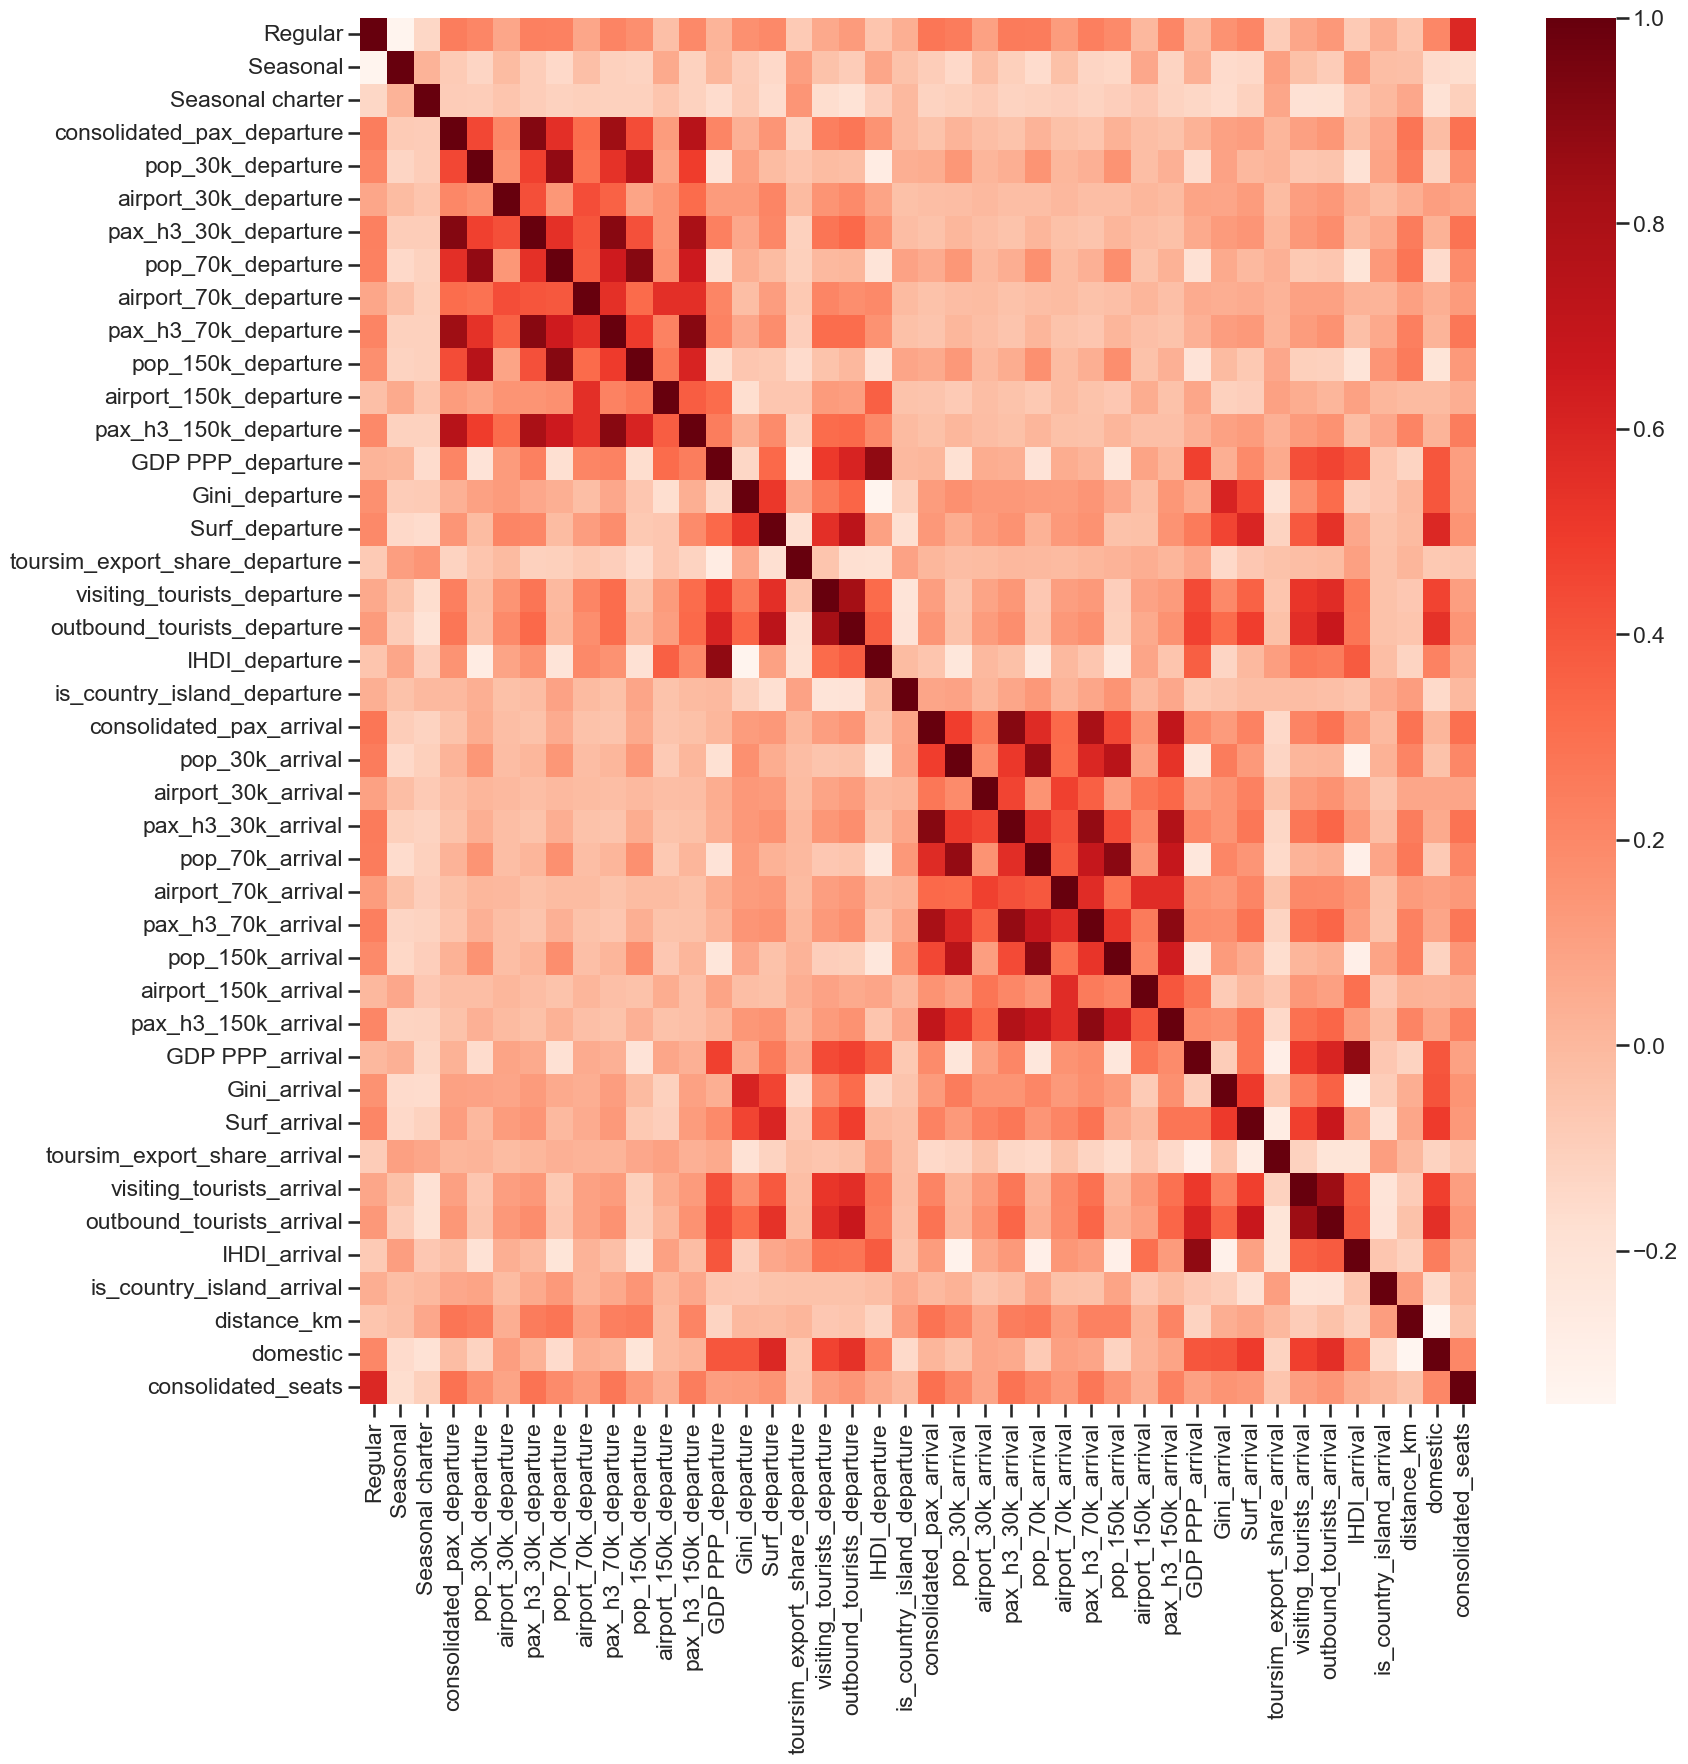

In [128]:
import matplotlib

matplotlib.rc_params({"fontsize": 9})
cor = routes_num_only.corr()
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(cor, cmap=plt.cm.Reds, ax=ax)
plt.show()

In [129]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
import warnings

warnings.filterwarnings("ignore")

Using the previous correlation heatmap we first mannualy remove redundant varaibles

In [130]:
col_list = [
    "Regular",
    "Seasonal",
    "Seasonal charter",
    "consolidated_pax_departure",
    "pop_70k_departure",
    "airport_70k_departure",
    "GDP PPP_departure",
    "Gini_departure",
    "Surf_departure",
    "toursim_export_share_departure",
    "visiting_tourists_departure",
    "outbound_tourists_departure",
    "IHDI_departure",
    "is_country_island_departure",
    "consolidated_pax_arrival",
    "pop_70k_arrival",
    "airport_70k_arrival",
    "GDP PPP_arrival",
    "Gini_arrival",
    "Surf_arrival",
    "toursim_export_share_arrival",
    "visiting_tourists_arrival",
    "outbound_tourists_arrival",
    "IHDI_arrival",
    "is_country_island_arrival",
    "distance_km",
    "consolidated_seats",
]

simplified_df = routes_num_only[col_list]

We'll use a LASSO (L1) regularisation to deal with remaining colinearity. https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/

In [133]:
X = simplified_df.drop(columns=["consolidated_seats"]).copy()
y = simplified_df["consolidated_seats"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=12
)

In [134]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model = LassoCV(
    alphas=np.arange(0, 1000000, 1000), cv=cv, n_jobs=-1, fit_intercept=False
)
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print("alpha: %f" % model.alpha_)
RSME_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train))).round(2)
RSME_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test))).round(2)
print("RMSE train: %f" % RSME_train)
print("RMSE test: %f" % RSME_test)
r2 = r2_score(y_test, model.predict(X_test))
print("R2:\t", r2.round(3))

alpha: 0.000000
RMSE train: 280821.390000
RMSE test: 333871.590000
R2:	 0.382


Surpisingly, the lasso regularization is not usefull (alpha=0 (no regularisation) provides the best result). The r² is not improved.

In [135]:
model.coef_

array([ 1.66721540e+05,  1.21630069e+04,  2.72661174e+04,  3.59758028e-03,
       -9.78907624e-04,  1.62329371e+04,  1.94421363e+00, -1.43544608e+02,
        1.72104395e-03,  4.76273735e+02, -8.97127315e-05, -3.92666032e-04,
       -2.72567271e+05, -6.89647061e+04,  3.75214323e-03,  1.96684473e-04,
        1.52832604e+04,  2.51665787e+00,  4.61454927e+03, -3.60156724e-03,
        5.62649558e+02,  3.38732199e-05, -3.67969570e-04, -2.41630333e+05,
       -3.75968937e+04, -2.51761221e+01])

We'll therefore try to simplify further, and to introduce non linearities using log-linear regression.

The idea is to test a very simple gravity model, in the form of:

$P_{12} = \frac{P_1^{x_p} \times P_2^{x_p} \times I_1^{x_i} \times I_2^{x_i}}{D_{12}}$

Where $P_i$ is the population in the vicinity of airport $i$, $I_i$ the Income per habitant in the country and $D_{ij}$ the distance between two airports

In [136]:
col_list = [
    "pop_70k_departure",
    "GDP PPP_departure",
    "pop_70k_arrival",
    "GDP PPP_arrival",
    "distance_km",
    "consolidated_seats",
]

simplified_df = routes_num_only[col_list]
simplified_df["pop_prod"] = (
    simplified_df["pop_70k_departure"] * simplified_df["pop_70k_arrival"]
)
simplified_df["gdp_prod"] = (
    simplified_df["GDP PPP_departure"] * simplified_df["GDP PPP_arrival"]
)
col_list = ["pop_prod", "gdp_prod", "distance_km", "consolidated_seats"]


simplified_df = simplified_df[col_list]
simplified_df = simplified_df[(simplified_df != 0).all(1)]

In [137]:
simplified_df = np.log(simplified_df)

In [138]:
X = simplified_df.drop(columns=["consolidated_seats"]).copy()
y = simplified_df["consolidated_seats"]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=12
)

In [140]:
model = LinearRegression()
model.fit(X_train, y_train)
b0 = model.intercept_.round(2)
b1 = model.coef_.round(2)

y_predict = model.predict(X_test)

In [141]:
b0, b1

(-6.21, array([ 0.4 ,  0.38, -0.32]))

In [150]:
r2 = r2_score(np.exp(y_test), np.exp(y_predict))
r2

0.05051047319198432

In [151]:
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_predict)))

The r² is smaller than before, but that's not surprinsing given the low number of parameters used. Parameters could be added, but with constraints on zeros, that must be removed from the dataset before taking the log of the dataframe. 

<Axes: ylabel='Count'>

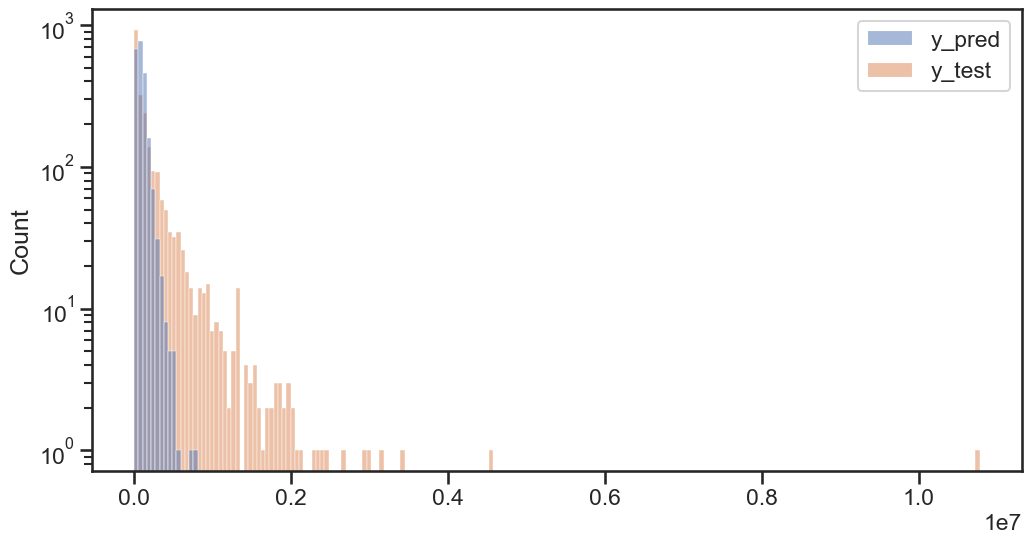

In [152]:
import matplotlib.pyplot as plt

data_dict = {"y_pred": np.exp(y_predict), "y_test": np.exp(y_test)}
df = pd.DataFrame(data_dict)
sns.set(style="ticks", context="talk", rc={"figure.figsize": (12, 6)})
plt.yscale("log")

sns.histplot(df, bins=200)

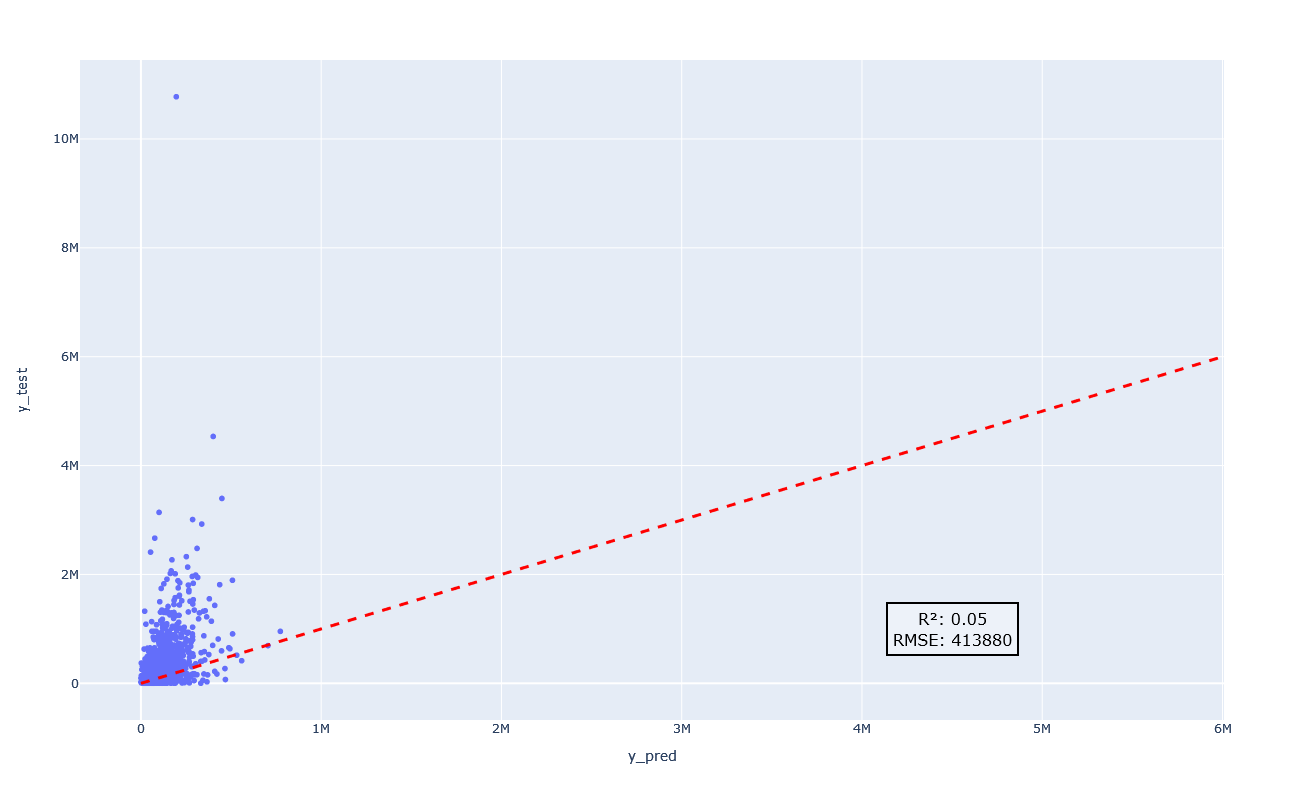

In [153]:
fig_llr = px.scatter(df, x="y_pred", y="y_test", width=800, height=800)
fig_llr.add_shape(
    type="line",
    x0=0,
    x1=6e6,
    y0=0,
    y1=6e6,
    line=dict(color="red", width=3, dash="dash"),
)

# Add text annotation
fig_llr.add_annotation(
    text="R²: {}<br>RMSE: {}".format(
        r2.round(2), int(rmse)
    ),  # Replace with your desired text
    x=4.5e6,  # X-coordinate of the text
    y=1e6,  # Y-coordinate of the text
    showarrow=False,  # To hide the arrow
    font=dict(size=16, color="black"),  # Customize the font style
    bgcolor="rgba(255, 255, 255, 0.3)",  # Background color with transparency
    bordercolor="black",  # Border color
    borderwidth=2,  # Border width
    borderpad=4,  # Padding for the border
)

fig_llr

Despite solving the problem of negative estimation by consctruction , the log linear estimator is very bad at predicting higghly frequented routes.

## Random Forest

To handle the apparent non-linearity of our probleme and at the same time the possible colinearity of the variables, an option is to use regression trees, and especially random forest of weak trees. Despite a long training time, they are weel suited for correlated variables and have no over-fit (randomness of the process). 

They are introduced in:
https://towardsdatascience.com/random-forest-regression-5f605132d19d

In [46]:
routes_xgb = routes_df_known[
    [
        "Regular",
        "Seasonal",
        "Seasonal charter",
        "consolidated_pax_departure",
        "pop_70k_departure",
        "airport_70k_departure",
        "GDP PPP_departure",
        "Gini_departure",
        "Surf_departure",
        "toursim_export_share_departure",
        "visiting_tourists_departure",
        "outbound_tourists_departure",
        "IHDI_departure",
        "is_country_island_departure",
        "consolidated_pax_arrival",
        "pop_70k_arrival",
        "airport_70k_arrival",
        "GDP PPP_arrival",
        "Gini_arrival",
        "Surf_arrival",
        "toursim_export_share_arrival",
        "visiting_tourists_arrival",
        "outbound_tourists_arrival",
        "IHDI_arrival",
        "is_country_island_arrival",
        "trade_value",
        "distance_km",
        "consolidated_seats",
    ]
]

# If using random forest, must eliminate NaN

q1 = routes_xgb.quantile(0.001)

routes_xgb.fillna(q1, inplace=True)

X = routes_xgb.drop(columns=["consolidated_seats"]).copy()
cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    X[col] = X[col].astype("category")

y = routes_xgb["consolidated_seats"]

# if using XGBRegressor or random forest, not handling categorical values
# X.drop(columns={'ISO_country_departure','ISO_country_arrival'}, inplace=True)

# If using radnom forest, NaN not possible and trade value for domestic flights has no real signification
X.drop(columns={"trade_value"}, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=12
)

Training the random forest regressor. Note that the code structure allows hyperparameter tuning, but only optimal values are input here to save running time.  Feel free to add more values.

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer


# Define the random forest regressor model
rf_model = RandomForestRegressor()

# # Define the hyperparameters to tune
hyperparameters = {
    "n_estimators": [1000],
    "min_samples_split": [5],
    "min_samples_leaf": [2],
}

# # Define the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# # Perform grid search cross-validation to find the best hyperparameters
grid_cv = GridSearchCV(
    estimator=rf_model, param_grid=hyperparameters, cv=5, scoring=scorer
)
grid_cv.fit(X_train, y_train)

# # Get the best hyperparameters and model
best_params = grid_cv.best_params_
best_model = grid_cv.best_estimator_

# Evaluate the model on the testing set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Test RMSE:", np.sqrt(mse))

Best Hyperparameters: {'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000}
Test RMSE: 193506.13292610872


In [51]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2fisrt

0.7105021700861596

The r² score is drastically improved by the random forest regressor!

<Axes: ylabel='Count'>

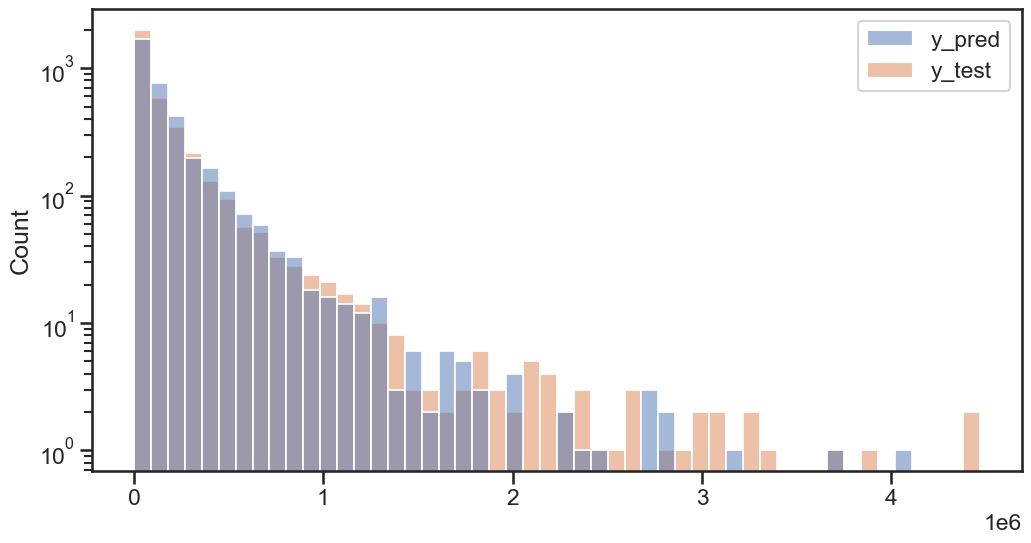

In [52]:
# import plotly.express as px

# Create a dictionary from the x and y vectors
data_dict = {"y_pred": y_pred, "y_test": y_test}
df = pd.DataFrame(data_dict)
sns.set(style="ticks", context="talk", rc={"figure.figsize": (12, 6)})
plt.yscale("log")
sns.histplot(df, bins=50)

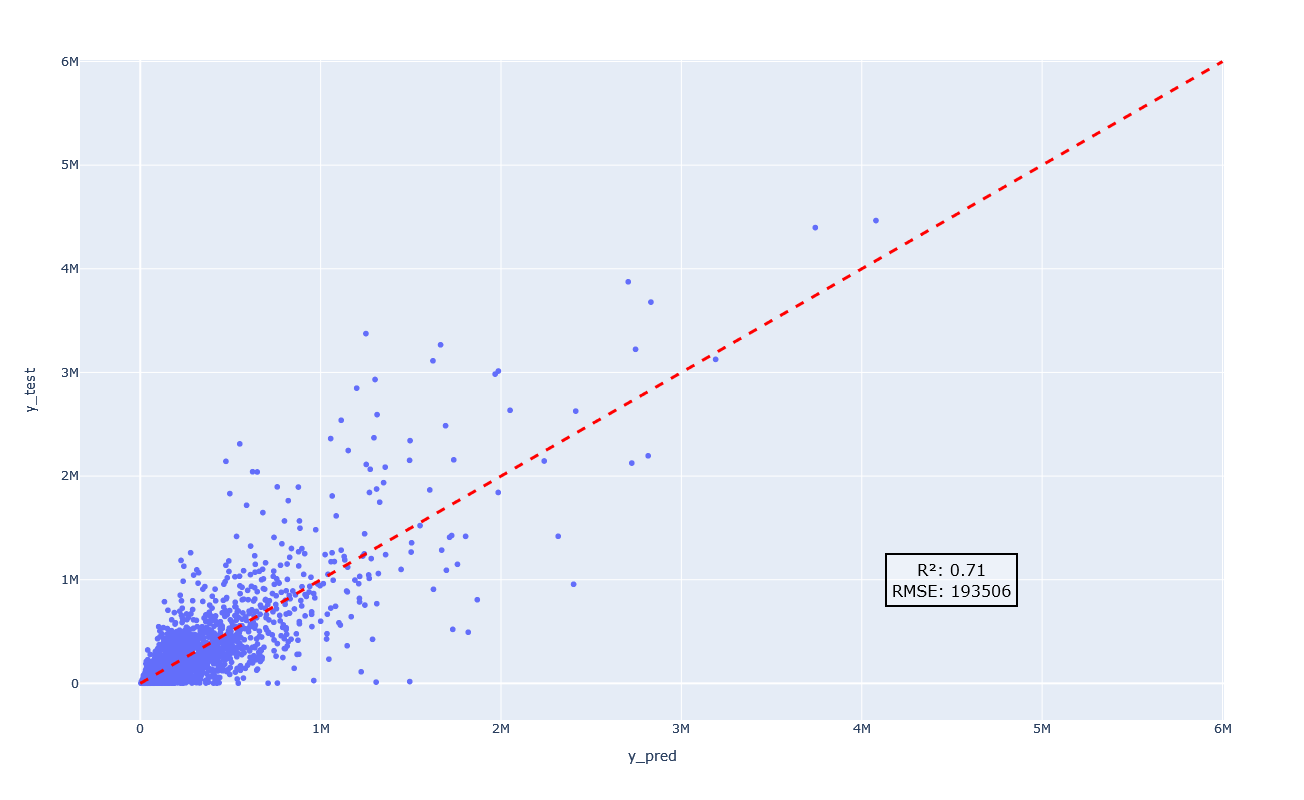

In [54]:
fig_rd = px.scatter(df, x="y_pred", y="y_test", width=800, height=800)
fig_rd.add_shape(
    type="line",
    x0=0,
    x1=6e6,
    y0=0,
    y1=6e6,
    line=dict(color="red", width=3, dash="dash"),
)

# Add text annotation
fig_rd.add_annotation(
    text="R²: {}<br>RMSE: {}".format(
        r2.round(2), int(rmse)
    ),  # Replace with your desired text
    x=4.5e6,  # X-coordinate of the text
    y=1e6,  # Y-coordinate of the text
    showarrow=False,  # To hide the arrow
    font=dict(size=16, color="black"),  # Customize the font style
    bgcolor="rgba(255, 255, 255, 0.3)",  # Background color with transparency
    bordercolor="black",  # Border color
    borderwidth=2,  # Border width
    borderpad=4,  # Padding for the border
)

fig_rd

## XGBOOST

Random forest are by definition a cobinaison of different weak predictors.  
To improve the training, we'll test gradient based regression trees, and more specifically XGBoost, a fast and efficent algorithm described in:  
https://www.youtube.com/watch?v=OtD8wVaFm6E&pp=ugMICgJmchABGAHKBQd4Z2Jvb3N0

Moreover, XGBoost handles well NaN in the dataset and is very fast.
It allows to use the raw dataset, and eventually to capture what a NaN means for the regression instead of removing them or to impute a given value.

In [163]:
from xgboost import XGBRegressor, DMatrix
import xgboost as xgb
from sklearn.metrics import r2_score


routes_xgb = routes_df_known[
    [
        "Regular",
        "Seasonal",
        "Seasonal charter",
        "consolidated_pax_departure",
        "pop_30k_departure",
        "airport_30k_departure",
        "pax_h3_30k_departure",
        "pop_70k_departure",
        "airport_70k_departure",
        "pax_h3_70k_departure",
        "airport_150k_departure",
        "pax_h3_150k_departure",
        "GDP PPP_departure",
        "Gini_departure",
        "toursim_export_share_departure",
        "visiting_tourists_departure",
        "outbound_tourists_departure",
        "IHDI_departure",
        "consolidated_pax_arrival",
        "pop_30k_arrival",
        "airport_30k_arrival",
        "pax_h3_30k_arrival",
        "pop_70k_arrival",
        "airport_70k_arrival",
        "pax_h3_70k_arrival",
        "airport_150k_arrival",
        "pax_h3_150k_arrival",
        "GDP PPP_arrival",
        "Gini_arrival",
        "toursim_export_share_arrival",
        "visiting_tourists_arrival",
        "outbound_tourists_arrival",
        "IHDI_arrival",
        "trade_value",
        "distance_km",
        "ISO_country_departure",
        "ISO_country_arrival",
        "domestic",
        "consolidated_seats",
    ]
]


X = routes_xgb.drop(columns=["consolidated_seats"]).copy()
cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    X[col] = X[col].astype("category")

y = routes_xgb["consolidated_seats"]

# if using XGBRegressor or random forest, not handling categorical values
X.drop(columns={"ISO_country_departure", "ISO_country_arrival"}, inplace=True)

Evaluation on several random train/test splits to have an idea of possible r².


[0]	train-mae:1453241.20231	validation-mae:1452713.25754
[100]	train-mae:48145.19591	validation-mae:87994.40519
[200]	train-mae:32130.21847	validation-mae:85238.17236
[249]	train-mae:27339.11112	validation-mae:85165.72964
[0]	train-mae:1453009.62502	validation-mae:1452096.93813
[100]	train-mae:47286.79135	validation-mae:90321.43778
[156]	train-mae:37074.94434	validation-mae:89172.18172
[0]	train-mae:1453218.29915	validation-mae:1451966.18902
[100]	train-mae:46709.91524	validation-mae:92762.83148
[139]	train-mae:39158.38599	validation-mae:92477.27296
[0]	train-mae:1451961.99477	validation-mae:1454670.80838
[100]	train-mae:47391.46837	validation-mae:90429.63563
[169]	train-mae:35292.44751	validation-mae:89313.59868
[0]	train-mae:1453371.02955	validation-mae:1451229.39003
[100]	train-mae:47890.01816	validation-mae:88549.42386
[111]	train-mae:45591.94252	validation-mae:88422.13976
[0]	train-mae:1452162.43369	validation-mae:1455693.00082
[100]	train-mae:47041.44907	validation-mae:89965.1072

<Axes: ylabel='Count'>

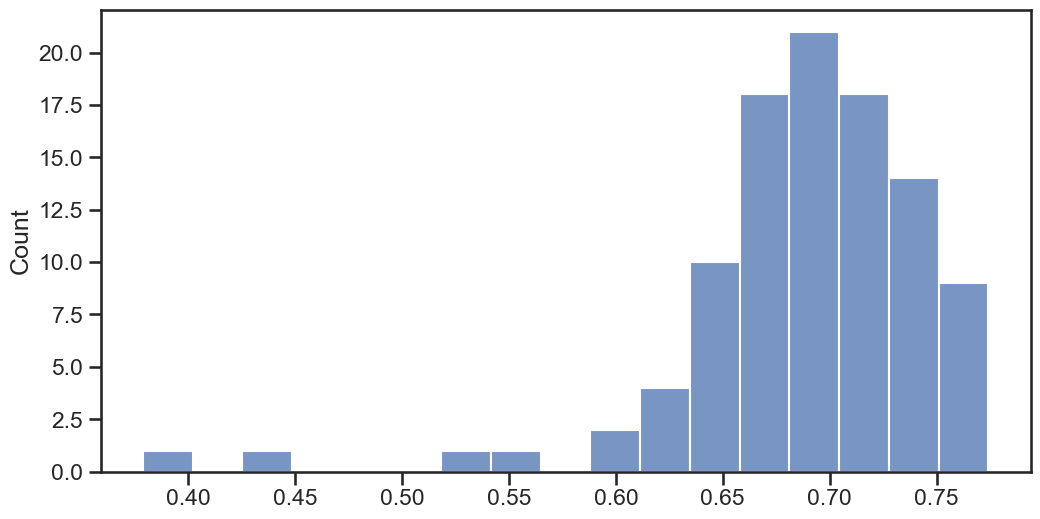

In [56]:
r2_list = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

    dtrain_reg = DMatrix(X_train, y_train, enable_categorical=True)
    dtest_reg = DMatrix(X_test, y_test, enable_categorical=True)

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    # A teedie regressor is used in the XGBoost alorithm since it is well suited for right-skewed data as our.
    # The tweedie variance power was chosen by hypermarameter tuning. Feel free to modify.
    params = {
        "objective": "reg:tweedie",
        "tree_method": "auto",
        "eval_metric": "mae",
        "tweedie_variance_power": 1.02,
    }
    n = 500

    model = xgb.train(
        params=params,
        dtrain=dtrain_reg,
        num_boost_round=n,
        evals=evals,
        verbose_eval=100,
        early_stopping_rounds=20,
    )

    y_pred = model.predict(dtest_reg)
    y_pred_train = model.predict(dtrain_reg)
    r2 = r2_score(y_test, y_pred)
    if r2 > 0 and r2 < 1:
        r2_list.append(r2)


sns.histplot(r2_list)

## Another way to use XGB

# model = XGBRegressor(
#     objective="reg:tweedie",
#     tree_method="auto",
#     eval_metric="tweedie-nloglik@1.004",
#     tweedie_variance_power=1.004,
#     n_estimators=500,
#     verbose=10,
#     early_stopping_rounds=10
# )
# model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

In [164]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)


dtrain_reg = DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = DMatrix(X_test, y_test, enable_categorical=True)


evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

# A teedie regressor is used in the XGBoost alorithm since it is well suited for right-skewed data as our.
# The tweedie variance power was chosen by hypermarameter tuning. Feel free to modify.
params = {
    "objective": "reg:tweedie",
    "tree_method": "auto",
    "eval_metric": "mae",
    "tweedie_variance_power": 1.02,
}
n = 500


model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=100,
    early_stopping_rounds=20,
)


y_pred = model.predict(dtest_reg)

[0]	train-mae:1452309.69236	validation-mae:1454736.37276
[100]	train-mae:47330.05274	validation-mae:88778.27852
[164]	train-mae:36682.28999	validation-mae:88675.71818


In [165]:
r2 = r2_score(y_test, y_pred)
r2

0.7159426334232081

The r² is improved compared to the random forest regressor. It remains below 0.7 however, and around 0.6 on average.

In [166]:
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmse

190339.88191740424

In [167]:
(y_pred.sum() + y_pred_train.sum()) / (y_test.sum() + y_train.sum())

0.9777088870455216

<Axes: ylabel='Count'>

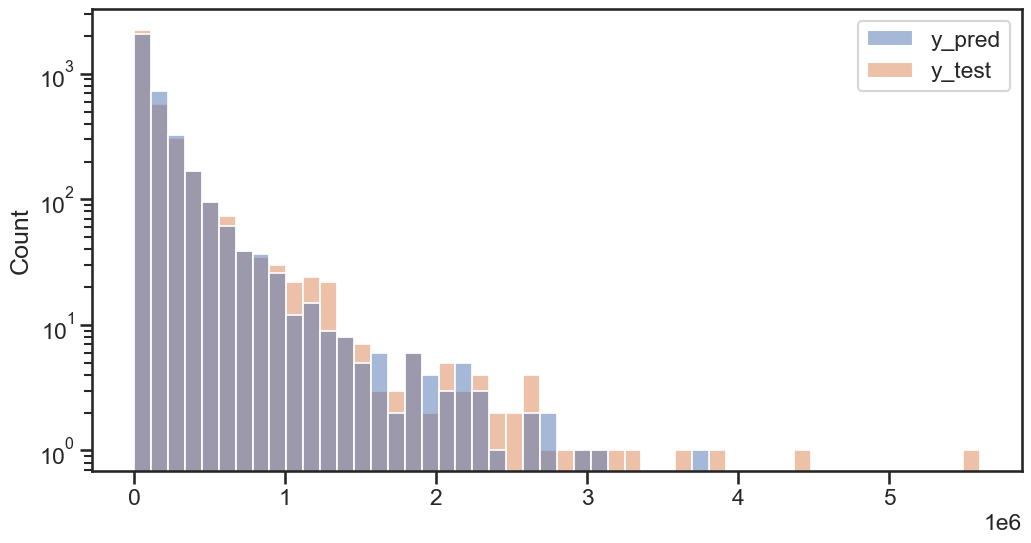

In [168]:
# import plotly.express as px

data_dict = {"y_pred": y_pred, "y_test": y_test}
df = pd.DataFrame(data_dict)
sns.set(style="ticks", context="talk", rc={"figure.figsize": (12, 6)})
plt.yscale("log")

sns.histplot(df, bins=50)

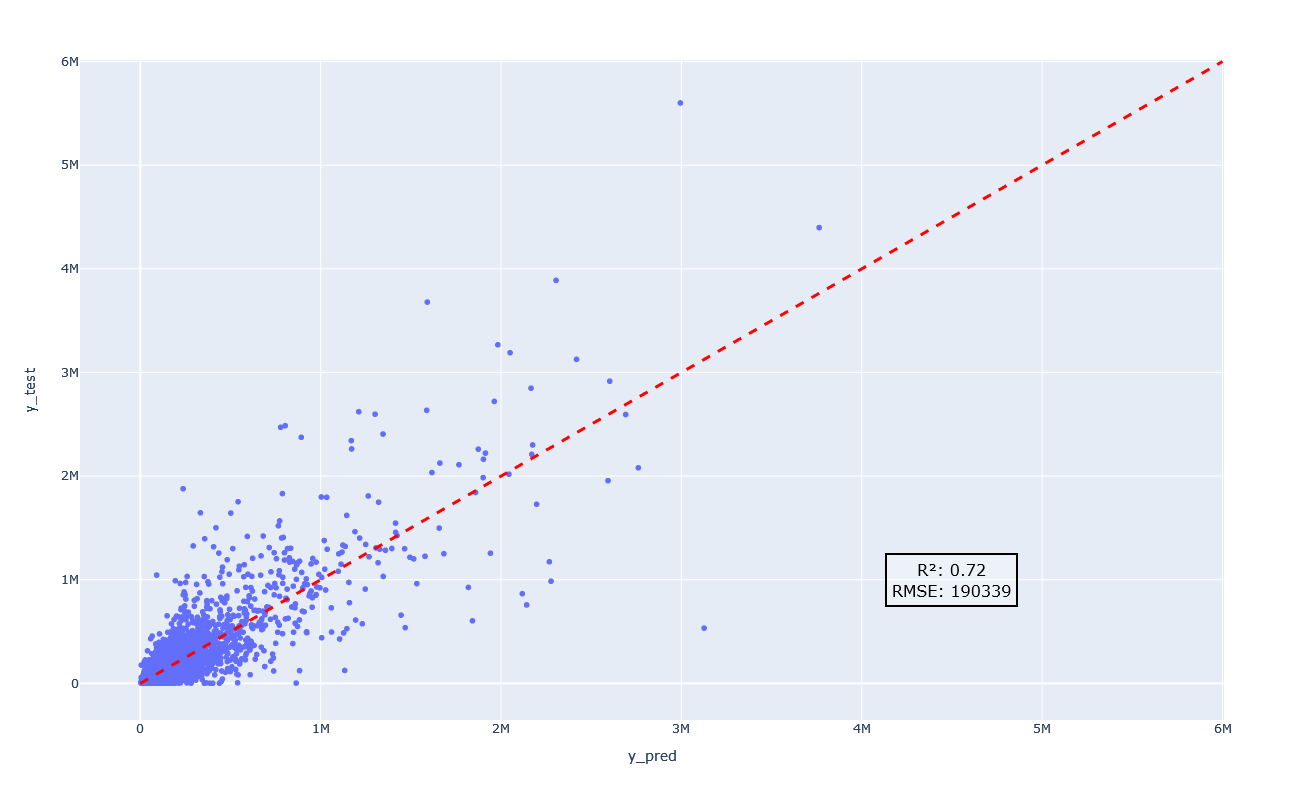

In [169]:
fig_xgb = px.scatter(df, x="y_pred", y="y_test", width=800, height=800)
fig_xgb.add_shape(
    type="line",
    x0=0,
    x1=6e6,
    y0=0,
    y1=6e6,
    line=dict(color="red", width=3, dash="dash"),
)


# Add text annotation
fig_xgb.add_annotation(
    text="R²: {}<br>RMSE: {}".format(
        r2.round(2), int(rmse)
    ),  # Replace with your desired text
    x=4.5e6,  # X-coordinate of the text
    y=1e6,  # Y-coordinate of the text
    showarrow=False,  # To hide the arrow
    font=dict(size=16, color="black"),  # Customize the font style
    bgcolor="rgba(255, 255, 255, 0.3)",  # Background color with transparency
    bordercolor="black",  # Border color
    borderwidth=2,  # Border width
    borderpad=4,  # Padding for the border
)


fig_xgb

Training on full model: since we want to use the model on unknwn routes, the more existing routes included for the training, the better it is.  
Therefore train and test datasets are reunited in a final training dataset.

In [63]:
dfull_reg = DMatrix(X, y, enable_categorical=True)

evals = [(dfull_reg, "full")]
params = {
    "objective": "reg:tweedie",
    "tree_method": "auto",
    "eval_metric": "mae",
    "tweedie_variance_power": 1.02,
}
n = 500


model = xgb.train(
    params=params,
    dtrain=dfull_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=100,
    early_stopping_rounds=20,
)


y_pred = model.predict(dfull_reg)
r2_score(y, y_pred)

[0]	full-mae:1452962.60685
[100]	full-mae:50622.01014
[200]	full-mae:35248.78583
[300]	full-mae:27208.80652
[400]	full-mae:21621.04250
[499]	full-mae:17623.45239


0.9942323781909853

Obviously, since the whole data was used during the training phase, the r² is very good. 

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

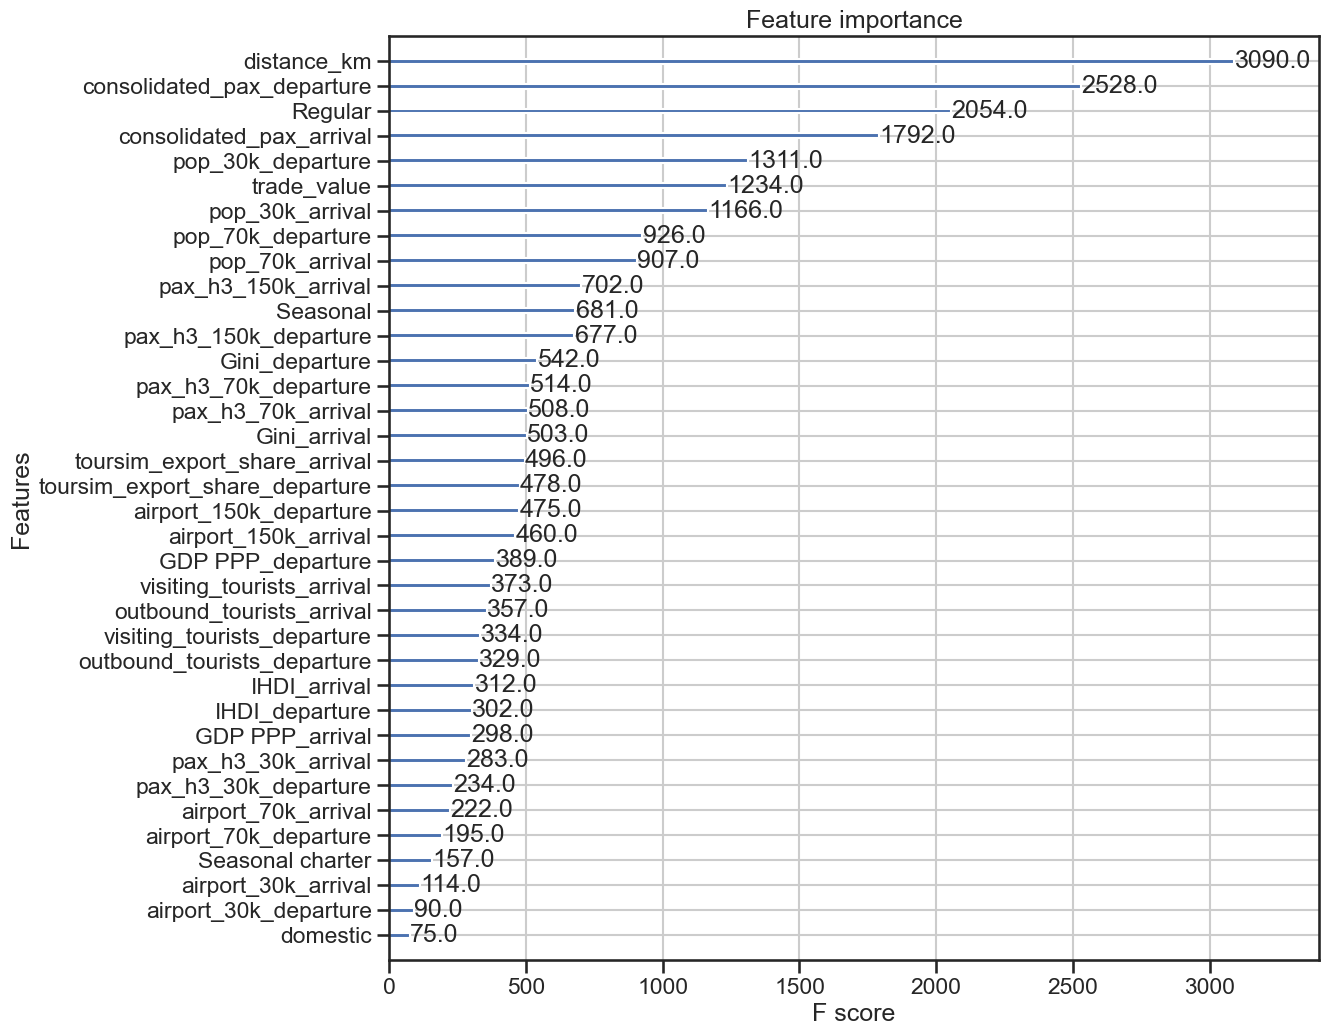

In [64]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, ax=ax)

The graph above ranks the parameters influence in the model. As we can see, the distance is the most influent parameter, followed by airport passenger traffic and number of airlines operating on the route on a regular basis. 
More detailed feature analysis can be use using the code below, but requires XGBRegressor model (sklearn wrapper) instead  of xgb 

In [65]:
# import explainerdashboard

In [66]:
# from explainerdashboard import RegressionExplainer, ExplainerDashboard
# explainer = RegressionExplainer(model, X_train, y_train, shap_kwargs=dict(check_additivity=False))

In [67]:
# ExplainerDashboard(explainer).run()

### Summary plot

In [55]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(
    rows=2,
    cols=2,
    shared_xaxes=True,
    shared_yaxes=True,
    subplot_titles=["Linear", "Log-Linear", "Random Forest", "XGBoost"],
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)

for trace in fig_lr["data"]:
    fig.add_trace(
        go.Scatter(
            x=trace.x,
            y=trace.y,
            mode="markers",
            marker_line_width=1,
            line=dict(color="#36616D"),
        ),
        row=1,
        col=1,
    )
    fig.add_shape(
        type="line",
        x0=0,
        x1=6e6,
        y0=0,
        y1=6e6,
        line=dict(color="red", width=3, dash="dash"),
        row=1,
        col=1,
    )

for trace in fig_llr["data"]:
    fig.add_trace(
        go.Scatter(
            x=trace.x,
            y=trace.y,
            mode="markers",
            marker_line_width=1,
            line=dict(color="#456B2B"),
        ),
        row=1,
        col=2,
    )
    fig.add_shape(
        type="line",
        x0=0,
        x1=6e6,
        y0=0,
        y1=6e6,
        line=dict(color="red", width=3, dash="dash"),
        row=1,
        col=2,
    )

for trace in fig_rd["data"]:
    trace.line.color = "purple"
    fig.add_trace(
        go.Scatter(
            x=trace.x,
            y=trace.y,
            mode="markers",
            marker_line_width=1,
            line=dict(color="#E09F3E"),
        ),
        row=2,
        col=1,
    )
    fig.add_shape(
        type="line",
        x0=0,
        x1=6e6,
        y0=0,
        y1=6e6,
        line=dict(color="red", width=3, dash="dash"),
        row=2,
        col=1,
    )

for trace in fig_xgb["data"]:
    fig.add_trace(
        go.Scatter(
            x=trace.x,
            y=trace.y,
            mode="markers",
            marker_line_width=1,
            line=dict(color="#9E2A2B"),
        ),
        row=2,
        col=2,
    )
    fig.add_shape(
        type="line",
        x0=0,
        x1=6e6,
        y0=0,
        y1=6e6,
        line=dict(color="red", width=3, dash="dash"),
        row=2,
        col=2,
    )


fig.update_layout(width=1000, height=1000, template="ggplot2")


fig.update_xaxes(
    range=[-0.5e6, 6e6], row=1, col=1, showline=True, showgrid=True, showticklabels=True
)
fig.update_xaxes(
    range=[-0.5e6, 6e6], row=1, col=2, showline=True, showgrid=True, showticklabels=True
)
fig.update_xaxes(
    range=[-0.5e6, 6e6],
    title="Estimation",
    row=2,
    col=1,
    showline=True,
    showgrid=True,
    showticklabels=True,
)
fig.update_xaxes(
    range=[-0.5e6, 6e6],
    title="Estimation",
    row=2,
    col=2,
    showline=True,
    showgrid=True,
    showticklabels=True,
)

fig.update_yaxes(
    range=[0, 6e6],
    title="Reference",
    row=1,
    col=1,
    showline=True,
    showgrid=True,
    showticklabels=True,
)
fig.update_yaxes(
    range=[0, 6e6], row=1, col=2, showline=True, showgrid=True, showticklabels=True
)
fig.update_yaxes(
    range=[0, 6e6],
    title="Reference",
    row=2,
    col=1,
    showline=True,
    showgrid=True,
    showticklabels=True,
)
fig.update_yaxes(
    range=[0, 6e6], row=2, col=2, showline=True, showgrid=True, showticklabels=True
)

fig.update_traces(opacity=0.9, showlegend=False)
fig.update_shapes(opacity=0.8)


fig.write_image("fig1.pdf")

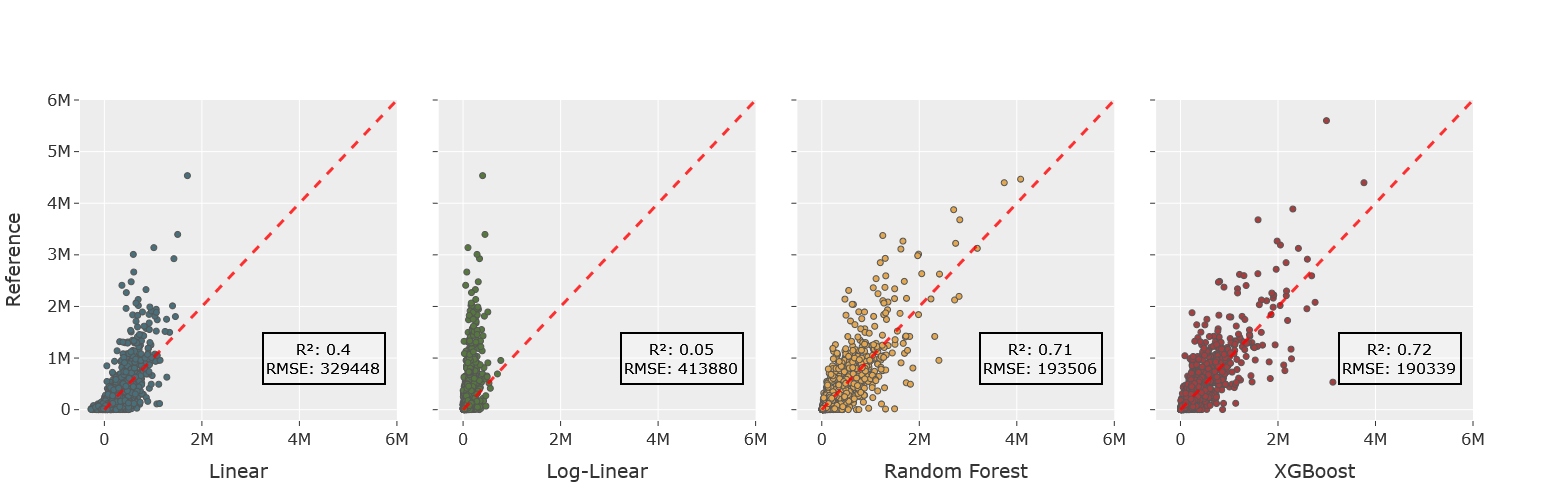

In [173]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(
    rows=1, cols=4, shared_xaxes=True, shared_yaxes=True, horizontal_spacing=0.03
)


for trace in fig_lr["data"]:
    fig.add_trace(
        go.Scatter(
            x=trace.x,
            y=trace.y,
            mode="markers",
            marker_line_width=1,
            line=dict(color="#36616D"),
        ),
        row=1,
        col=1,
    )
    fig.add_shape(
        type="line",
        x0=0,
        x1=6e6,
        y0=0,
        y1=6e6,
        line=dict(color="red", width=3, dash="dash"),
        row=1,
        col=1,
    )

for annotation in fig_lr["layout"]["annotations"]:
    annotation = go.layout.Annotation(
        text=annotation.text,
        x=annotation.x,
        y=annotation.y,
        showarrow=annotation.showarrow,
        font=annotation.font,
        xanchor=annotation.xanchor,
        bgcolor="rgba(255, 255, 255, 0.3)",  # Background color with transparency
        bordercolor="black",  # Border color
        borderwidth=2,  # Border width
        borderpad=4,  # Padding for the border
    )
    fig.add_annotation(annotation, row=1, col=1)


for trace in fig_llr["data"]:
    fig.add_trace(
        go.Scatter(
            x=trace.x,
            y=trace.y,
            mode="markers",
            marker_line_width=1,
            line=dict(color="#456B2B"),
        ),
        row=1,
        col=2,
    )
    fig.add_shape(
        type="line",
        x0=0,
        x1=6e6,
        y0=0,
        y1=6e6,
        line=dict(color="red", width=3, dash="dash"),
        row=1,
        col=2,
    )

for annotation in fig_llr["layout"]["annotations"]:
    annotation = go.layout.Annotation(
        text=annotation.text,
        x=annotation.x,
        y=annotation.y,
        showarrow=annotation.showarrow,
        font=annotation.font,
        xanchor=annotation.xanchor,
        bgcolor="rgba(255, 255, 255, 0.3)",  # Background color with transparency
        bordercolor="black",  # Border color
        borderwidth=2,  # Border width
        borderpad=4,  # Padding for the border
    )
    fig.add_annotation(annotation, row=1, col=2)

for trace in fig_rd["data"]:
    trace.line.color = "purple"
    fig.add_trace(
        go.Scatter(
            x=trace.x,
            y=trace.y,
            mode="markers",
            marker_line_width=1,
            line=dict(color="#E09F3E"),
        ),
        row=1,
        col=3,
    )
    fig.add_shape(
        type="line",
        x0=0,
        x1=6e6,
        y0=0,
        y1=6e6,
        line=dict(color="red", width=3, dash="dash"),
        row=1,
        col=3,
    )

for annotation in fig_rd["layout"]["annotations"]:
    annotation = go.layout.Annotation(
        text=annotation.text,
        x=annotation.x,
        y=annotation.y,
        showarrow=annotation.showarrow,
        font=annotation.font,
        xanchor=annotation.xanchor,
        bgcolor="rgba(255, 255, 255, 0.3)",  # Background color with transparency
        bordercolor="black",  # Border color
        borderwidth=2,  # Border width
        borderpad=4,  # Padding for the border
    )
    fig.add_annotation(annotation, row=1, col=3)


for trace in fig_xgb["data"]:
    fig.add_trace(
        go.Scatter(
            x=trace.x,
            y=trace.y,
            mode="markers",
            marker_line_width=1,
            line=dict(color="#9E2A2B"),
        ),
        row=1,
        col=4,
    )
    fig.add_shape(
        type="line",
        x0=0,
        x1=6e6,
        y0=0,
        y1=6e6,
        line=dict(color="red", width=3, dash="dash"),
        row=1,
        col=4,
    )

for annotation in fig_xgb["layout"]["annotations"]:
    annotation = go.layout.Annotation(
        text=annotation.text,
        x=annotation.x,
        y=annotation.y,
        showarrow=annotation.showarrow,
        font=annotation.font,
        xanchor=annotation.xanchor,
        bgcolor="rgba(255, 255, 255, 0.3)",  # Background color with transparency
        bordercolor="black",  # Border color
        borderwidth=2,  # Border width
        borderpad=4,  # Padding for the border
    )
    fig.add_annotation(annotation, row=1, col=4)

fig.update_layout(width=1500, height=500, template="ggplot2", font=dict(size=16))

fig.update_xaxes(
    range=[-0.5e6, 6e6],
    title="Linear",
    row=1,
    col=1,
    showline=True,
    showgrid=True,
    showticklabels=True,
)
fig.update_xaxes(
    range=[-0.5e6, 6e6],
    title="Log-Linear",
    row=1,
    col=2,
    showline=True,
    showgrid=True,
    showticklabels=True,
)
fig.update_xaxes(
    range=[-0.5e6, 6e6],
    title="Random Forest",
    row=1,
    col=3,
    showline=True,
    showgrid=True,
    showticklabels=True,
)
fig.update_xaxes(
    range=[-0.5e6, 6e6],
    title="XGBoost",
    row=1,
    col=4,
    showline=True,
    showgrid=True,
    showticklabels=True,
)
fig.update_yaxes(
    range=[-0.2e6, 6e6],
    title="Reference",
    row=1,
    col=1,
    showline=True,
    showgrid=True,
    showticklabels=True,
)

fig.update_traces(opacity=0.9, showlegend=False)
fig.update_shapes(opacity=0.8)
fig.update_annotations(font_size=15)

# Show the subplots
fig.show()

fig.write_image("fig1b.pdf")

## Predicting unknown seats 

For xgboost only. Exact steps but with the whole dataset, including the routes where the dependent variable is unknown.
Steps to do it with random forest are commented.

In [57]:
routes_xgb_predict = routes_df[
    [
        "Regular",
        "Seasonal",
        "Seasonal charter",
        "consolidated_pax_departure",
        "pop_30k_departure",
        "airport_30k_departure",
        "pax_h3_30k_departure",
        "pop_70k_departure",
        "airport_70k_departure",
        "pax_h3_70k_departure",
        "airport_150k_departure",
        "pax_h3_150k_departure",
        "GDP PPP_departure",
        "Gini_departure",
        "toursim_export_share_departure",
        "visiting_tourists_departure",
        "outbound_tourists_departure",
        "IHDI_departure",
        "consolidated_pax_arrival",
        "pop_30k_arrival",
        "airport_30k_arrival",
        "pax_h3_30k_arrival",
        "pop_70k_arrival",
        "airport_70k_arrival",
        "pax_h3_70k_arrival",
        "airport_150k_arrival",
        "pax_h3_150k_arrival",
        "GDP PPP_arrival",
        "Gini_arrival",
        "toursim_export_share_arrival",
        "visiting_tourists_arrival",
        "outbound_tourists_arrival",
        "IHDI_arrival",
        "trade_value",
        "distance_km",
        "ISO_country_departure",
        "ISO_country_arrival",
        "domestic",
        "consolidated_seats",
    ]
]


X = routes_xgb_predict.drop(columns=["consolidated_seats"]).copy()
cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    X[col] = X[col].astype("category")

y = routes_xgb_predict["consolidated_seats"]

# if using XGBRegressor, not handling categorical values
X.drop(columns={"ISO_country_departure", "ISO_country_arrival"}, inplace=True)
# X.drop(columns={'trade_value'}, inplace=True)


d_reg = DMatrix(X)

In [58]:
routes_df_0["predicted_seats_xgb"] = model.predict(d_reg)
# routes_df_0['predicted_seats_rdf'] = best_model.predict(X)

## Saving the dataset

In [59]:
routes_df_0.to_csv("data/routes_est_26_09.csv")

Bonus: Check what would happen if mixing rdf and XGB.

In [60]:
# # import plotly.express as px

# test=routes_df_0[~routes_df_0['consolidated_seats'].isna()]

# test['xgb_x_rdf']=(test['predicted_seats_rdf']+test['predicted_seats_xgb'])/2

# # Create a dictionary from the x and y vectors
# data_dict = {"y_pred_rdf": test['predicted_seats_rdf'], "y_pred_xgb": test['predicted_seats_xgb'],"y_concept": test['xgb_x_rdf'],"y_test": y}

# # Convert the dictionary to a Pandas DataFrame
# df = pd.DataFrame(data_dict)

# # # Create a scatterplot with ke


# # Set the Seaborn style and context
# sns.set(style="ticks", context="talk", rc={"figure.figsize": (12, 6)})
# plt.yscale("log")

# sns.histplot(df, bins=50)

In [61]:
# y_pred_rdf = best_model.predict(X_test)

In [62]:
# y_pred_xgb = model.predict(dtest_reg)

In [63]:
# r2_score(y_pred_xgb,y_pred_rdf)

Pretty big correlation between xgb and rdf! What if mixed?

In [64]:
# r2_score((y_pred_xgb+y_pred_rdf)/2,y_test)

Not interesting compared to XGB alone!